[*********************100%***********************]  1 of 1 completed
C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\mohan\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
MSE Results:
                  LSTM    BiLSTM    Linear
gaussian     0.002033  0.001473  0.001271
triangular   0.002167  0.001500  0.001476
sigmoid      0.001898  0.004543  0.001325
trapezoidal  0.005250  0.003679  0.003247


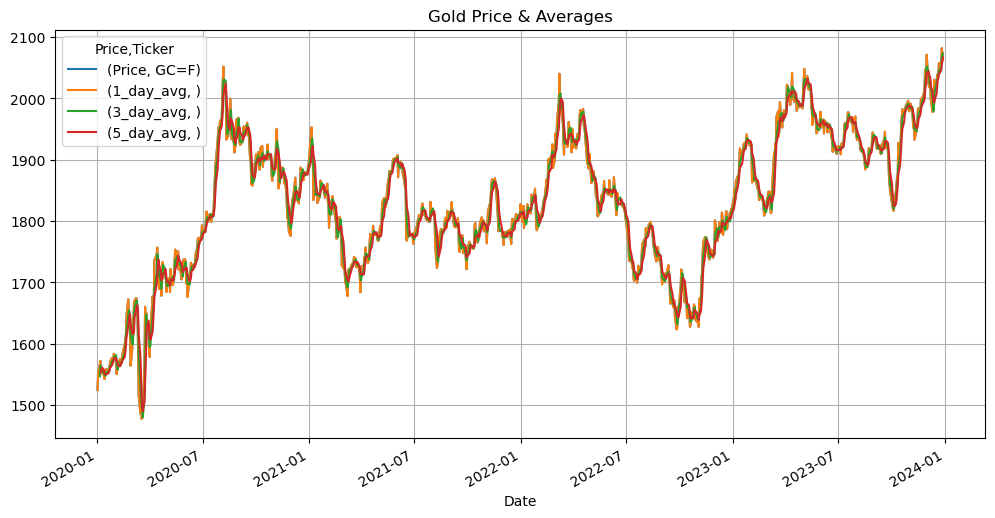

In [36]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# 1. Fetch gold price data using yfinance
data = yf.download('GC=F', start='2020-01-01', end='2023-12-31')
df = data[['Close']].rename(columns={'Close': 'Price'})
df.dropna(inplace=True)

# 2. Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)
if df.empty:
    raise ValueError("Downloaded data is empty. Check the symbol, date range, or internet connection.")

# 3. Fuzzy weight functions
def gaussian_fuzzy(x, mean=0.5, sigma=0.15):
    return fuzz.gaussmf(np.array([x]), mean, sigma)[0]

def triangular_fuzzy(x, a=0.2, b=0.5, c=0.8):
    return fuzz.trimf(np.array([x]), [a, b, c])[0]

def sigmoid_fuzzy(x, a=10, c=0.5):
    return fuzz.sigmf(np.array([x]), c, a)[0]

def trapezoidal_fuzzy(x, a=0.2, b=0.4, c=0.6, d=0.8):
    return fuzz.trapmf(np.array([x]), [a, b, c, d])[0]

def apply_fuzzy_weights(data, method):
    weights = []
    for val in data:
        x = val[0]
        if method == 'gaussian': w = gaussian_fuzzy(x)
        elif method == 'triangular': w = triangular_fuzzy(x)
        elif method == 'sigmoid': w = sigmoid_fuzzy(x)
        elif method == 'trapezoidal': w = trapezoidal_fuzzy(x)
        weights.append([w])
    return np.array(weights)

# 4. Prepare sequences
def create_sequences(data, window=3):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

# 5. Evaluate Models
def evaluate_model(X, y, model_type='lstm'):
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    if model_type == 'linear':
        X_lin = X.reshape((X.shape[0], X.shape[1]))
        model = LinearRegression().fit(X_lin[:split], y_train[:split])
        preds = model.predict(X_lin[split:])
    else:
        model = Sequential()
        if model_type == 'bilstm':
            model.add(Bidirectional(LSTM(50), input_shape=(X.shape[1], X.shape[2])))
        else:
            model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
        preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    return mse

# 6. Run experiments
results = {}
for fuzzy in ['gaussian', 'triangular', 'sigmoid', 'trapezoidal']:
    fuzzy_weights = apply_fuzzy_weights(data_scaled, fuzzy)
    weighted_data = data_scaled * fuzzy_weights
    X, y = create_sequences(weighted_data)

    results[fuzzy] = {
        'LSTM': evaluate_model(X, y, 'lstm'),
        'BiLSTM': evaluate_model(X, y, 'bilstm'),
        'Linear': evaluate_model(X, y, 'linear')
    }

# 7. Display Results
results_df = pd.DataFrame(results).T
print("MSE Results:\n", results_df)

# 8. Calculate moving averages
df['1_day_avg'] = df['Price'].rolling(window=1).mean()
df['3_day_avg'] = df['Price'].rolling(window=3).mean()
df['5_day_avg'] = df['Price'].rolling(window=5).mean()

# Optional: Plot
df[['Price', '1_day_avg', '3_day_avg', '5_day_avg']].plot(figsize=(12,6), title='Gold Price & Averages')
plt.grid()
plt.show()
